In [161]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh_TGV1')
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import Optics
from HHG import ActiveGrating
import Graph

Grating = Optics.Grating()

In [162]:
"4f Pulse shaper"

# Pulse en entrée
lam = 1030e-9
w0 = 3e8/lam * 2*np.pi
dt = 30e-15
dw = 2/dt
dx = 8e-3

# Grille dans le plan focal du shaper
Lx, Lw = 30*dx, 10*w0
Nx, Nw = 2000, 3000
x_axis = np.linspace(-Lx/2, Lx/2, Nx) 
w_axis = np.linspace(-Lw/2, Lw/2, Nw) 
xw_grid = np.meshgrid(x_axis, w_axis)
x, w = xw_grid

# Masque de phase
ell = 1
theta_sw = np.arctan2(x/dx, (w-w0)/dw)
MASK = np.exp(1j*ell*theta_sw)

# Shaped pulse
PULSE_sw = np.exp(-x**2/dx**2) * np.exp(-(w-w0)**2/dw**2) * MASK

# Pulse in time
PULSE_st, xt_grid = Grating.Recombine(field_0=PULSE_sw, grid_xt=xw_grid)
t = xt_grid[1]
t_axis = t.T[0]
Lt = t_axis[-1] - t_axis[0]

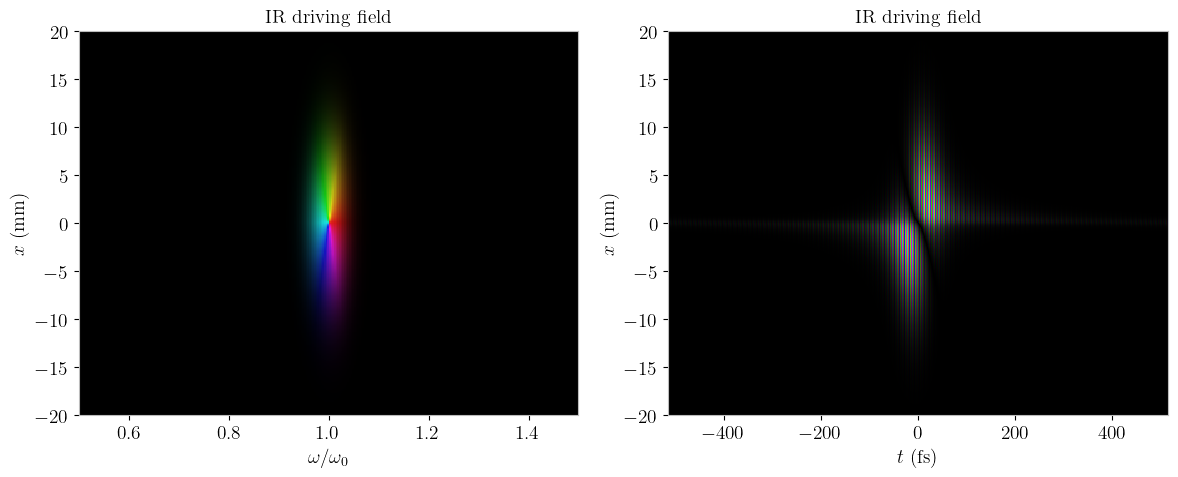

In [163]:
"Plot pulse at the output of shaper"
%matplotlib inline
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w_axis[0]/w0, w_axis[-1]/w0, x_axis[0]*1e3, x_axis[-1]*1e3]

im = Graph.Phase2D().colorize(PULSE_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(0.5, 1.5)
ax[0].set_ylim(-20,20)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel('$x$ (mm)')
ax[0].set_title('IR driving field')



'B - in xt plane'

extent=[t_axis[0]/1e-15, t_axis[-1]/1e-15, x_axis[0]*1e3, x_axis[-1]*1e3]

im = Graph.Phase2D().colorize(PULSE_st.T, mode='Amplitude')
ax[1].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_ylim(-20,20)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$t$ (fs)')
ax[1].set_ylabel('$x$ (mm)')
ax[1].set_title('IR driving field')

plt.show()

In [164]:
"Focusing the pulse"

# Lens
waist = 20e-6 # desired waist at focus
f = np.pi * waist * dx / lam # approx focal length needed to focus

# Pulse right after the lens
L_PULSE_sw = PULSE_sw #* np.exp(1j * (w/3e8) * x**2 / (2*f))

# Propagate each frequency component to the focus
FOC_PULSE_sw = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(L_PULSE_sw, axes=1), axis=1), axes=1)
FOC_PULSE_sw = FOC_PULSE_sw * (Lx/(Nx-1))
d = f
foc_x_axis = np.fft.fftshift(np.fft.fftfreq(Nx, Lx/(Nx-1)))*d
lam_axis = 2*np.pi*3e8/w

for i in range(len(FOC_PULSE_sw)):
    FOC_PULSE_sw[i] = np.interp(foc_x_axis*lam_axis[-1], foc_x_axis*lam_axis[i], FOC_PULSE_sw[i]) / lam_axis[i] 

foc_x_axis = foc_x_axis * lam_axis[-1]
foc_xw_grid = np.meshgrid(foc_x_axis, w_axis)
foc_x, w = foc_xw_grid
Lfoc_x = foc_x_axis[-1] - foc_x_axis[0]

FOC_PULSE_sw = FOC_PULSE_sw * np.exp(1j * (w/3e8) * foc_x**2 / (2*f))  * 1j

# Focused pulse in time
FOC_PULSE_st, foc_xt_grid = Grating.Recombine(field_0=FOC_PULSE_sw, grid_xt=foc_xw_grid)

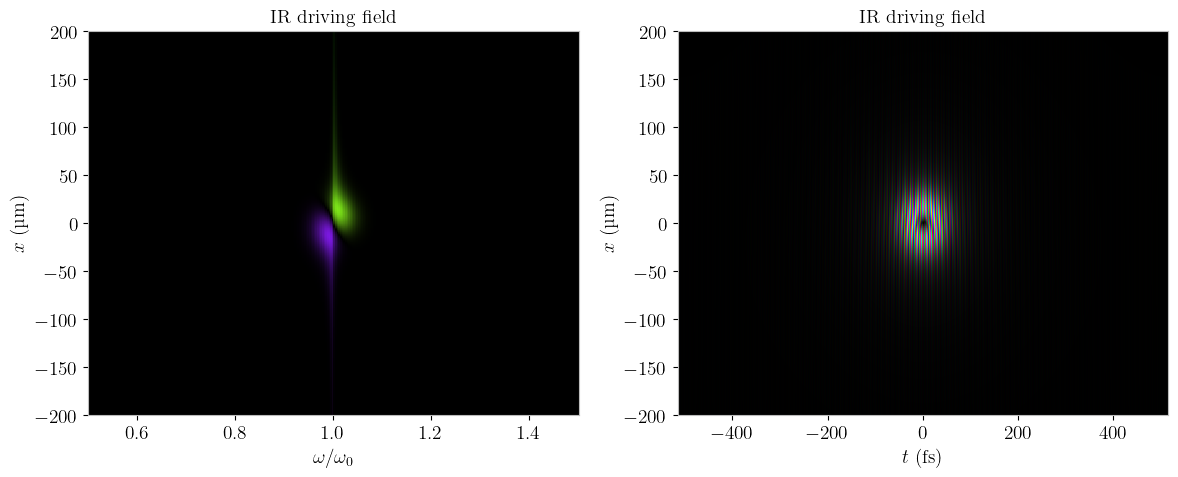

In [165]:
"Plot pulse at focus"
%matplotlib inline
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w_axis[0]/w0, w_axis[-1]/w0, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(FOC_PULSE_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(0.5, 1.5)
ax[0].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel('$x$ (µm)')
ax[0].set_title('IR driving field')



'B - in xt plane'

extent=[t_axis[0]/1e-15, t_axis[-1]/1e-15, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(FOC_PULSE_st.T, mode='Amplitude')
ax[1].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$t$ (fs)')
ax[1].set_ylabel('$x$ (µm)')
ax[1].set_title('IR driving field')

plt.show()

In [166]:
"HHG"

# Desired q range
q_list = [7, 9, 11]

# we want the frequency axis to span [-q-1, q+1]. We need to adjust N/T to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

max_w = (np.max(q_list)+3)*w0
factor = max_w /np.max(w_axis)*2 # by how much we must increase N/T
Lt2 = Lt/factor
t2_axis = np.linspace(-Lt2, Lt2, Nw)
foc_xt2_grid = np.meshgrid(foc_x_axis, t2_axis)

FOC_PULSE_st = FOC_PULSE_st.T
for i in range(len(FOC_PULSE_st)):
    FOC_PULSE_st[i] = np.interp(t2_axis, t_axis, FOC_PULSE_st[i])
FOC_PULSE_st = FOC_PULSE_st.T

# We apply the TSM formula to every time slice, for some harmonic orders q.
AG = ActiveGrating(qeff=3.5)
XUV_NF_st = 0

for q in q_list:
    XUV_NF_st += AG.Hq_NearField(IRfield=FOC_PULSE_st, q=q)

# XUV field in frequency
XUV_NF_sw, foc_xw2_grid = Grating.Disperse(field_0=XUV_NF_st, grid_xt=foc_xt2_grid)
w2 = foc_xw2_grid[1]
w2_axis = w2.T[0]
Lw2 = w2_axis[-1] - w2_axis[0]


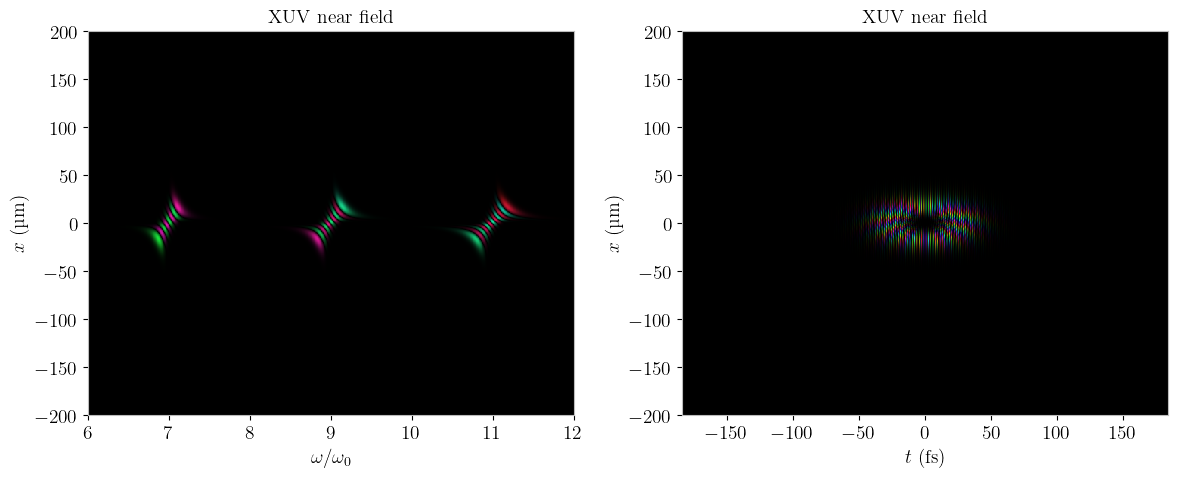

In [167]:
"Plot XUV near field"
%matplotlib inline
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(XUV_NF_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
#ax[0].set_xlim(0, np.max(q_list)+1)
ax[0].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel('$x$ (µm)')
ax[0].set_title('XUV near field')



'B - in xt plane'

extent=[t2_axis[0]/1e-15, t2_axis[-1]/1e-15, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(XUV_NF_st.T, mode='Amplitude')
ax[1].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$t$ (fs)')
ax[1].set_ylabel('$x$ (µm)')
ax[1].set_title('XUV near field')

plt.show()

In [168]:
"Propagate XUV to the far-field"

# we want the ff axis to roughly span [-lam/w0, lam/w0] ~20mrad . We need to adjust N/L to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

XUV_FF_sw = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(XUV_NF_sw, axes=1), axis=1), axes=1)
XUV_FF_sw = XUV_FF_sw * (Lfoc_x/(Nx-1))
d=1
ff_x_axis = np.fft.fftshift(np.fft.fftfreq(Nx, Lfoc_x/(Nx-1)))*d
lam2_axis = 2*np.pi*3e8/w2

for i in range(len(XUV_FF_sw)):
    XUV_FF_sw[i] = np.interp(ff_x_axis*lam2_axis[-1], ff_x_axis*lam2_axis[i], XUV_FF_sw[i]) / lam2_axis[i] 

ff_x_axis = ff_x_axis*lam2_axis[-1]

C:\Users\tg263331\AppData\Local\Temp\ipykernel_2708\3147173201.py:10: RuntimeWarning: divide by zero encountered in divide
  lam2_axis = 2*np.pi*3e8/w2
C:\Users\tg263331\AppData\Local\Temp\ipykernel_2708\3147173201.py:13: RuntimeWarning: invalid value encountered in multiply
  XUV_FF_sw[i] = np.interp(ff_x_axis*lam2_axis[-1], ff_x_axis*lam2_axis[i], XUV_FF_sw[i]) / lam2_axis[i]


c:\Users\tg263331\Anaconda3\envs\test_env\lib\site-packages\numpy\lib\function_base.py:2411: RuntimeWarning: invalid value encountered in hls_to_rgb (vectorized)
  outputs = ufunc(*inputs)


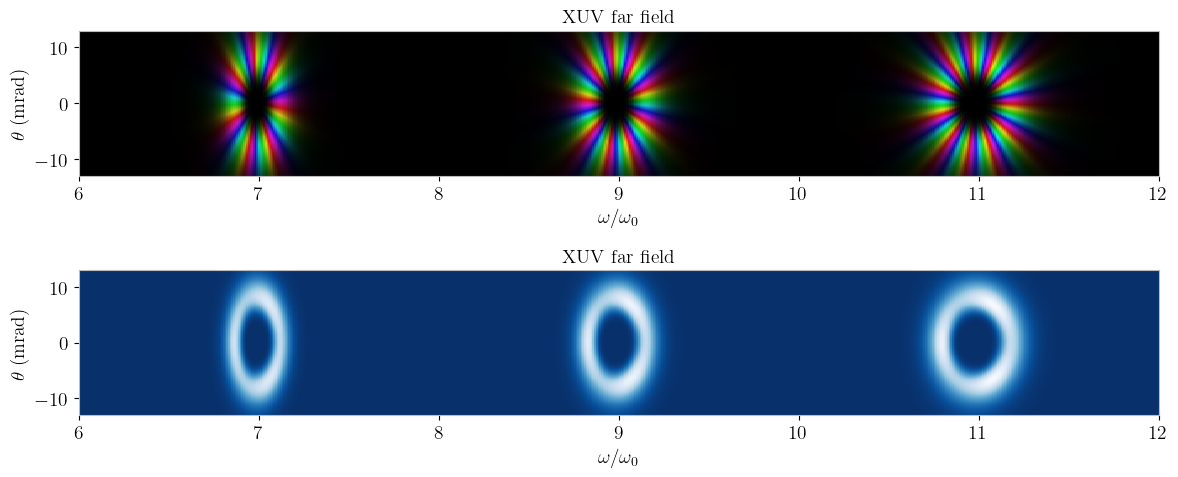

In [169]:
"Plot XUV far field"
%matplotlib inline
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, ff_x_axis[0]*1e3, ff_x_axis[-1]*1e3]

im = Graph.Phase2D().colorize(XUV_FF_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
#ax[0].set_xlim(0, np.max(q_list)+1)
ax[0].set_ylim(-13, 13)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel(r'$\theta$ (mrad)')
ax[0].set_title('XUV far field')



'B - plot intensity, xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, ff_x_axis[0]*1e3, ff_x_axis[-1]*1e3]

ax[1].imshow(np.abs(XUV_FF_sw.T)**2, aspect='auto', extent=extent, cmap='Blues_r')

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
ax[1].set_ylim(-13, 13)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$\omega/\omega_0$')
ax[1].set_ylabel(r'$\theta$ (mrad)')
ax[1].set_title('XUV far field')

plt.show()

In [170]:
"Add a reference pulse at focus"

# Offset
offset = -4 * waist
refwaist = waist
refdw = dw
scale = np.max(np.abs(FOC_PULSE_sw))/2 * 1.2

# Reference pulse
FOC_REF_sw = np.exp(-(foc_x - offset)**2/refwaist**2) * np.exp(-(w-w0)**2/refdw**2) * scale

BOTH_sw = FOC_PULSE_sw + FOC_REF_sw

# Focused pulse in time
BOTH_st, foc_xt_grid = Grating.Recombine(field_0=BOTH_sw, grid_xt=foc_xw_grid)

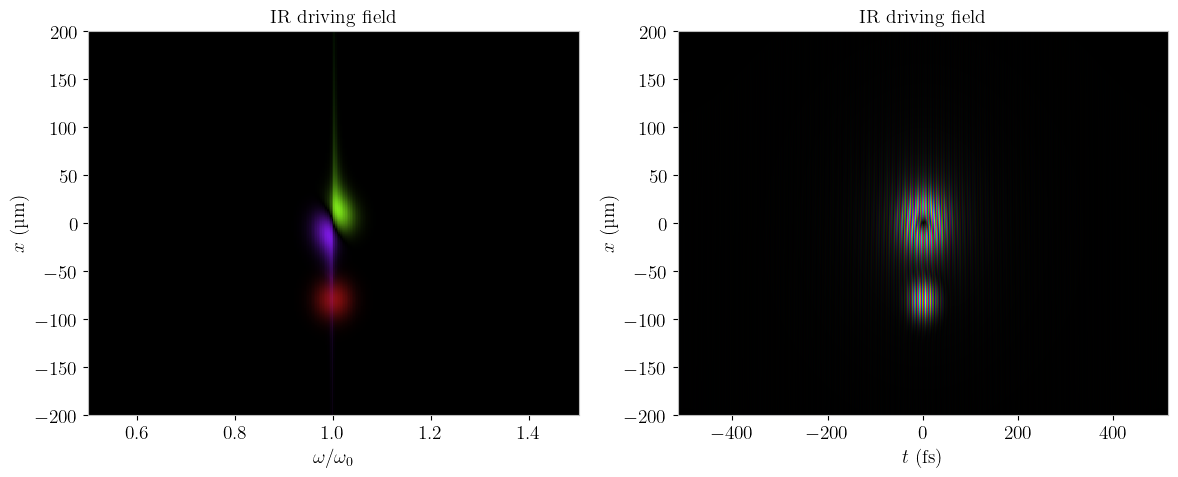

In [171]:
"Plot pulse at focus"
%matplotlib inline
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w_axis[0]/w0, w_axis[-1]/w0, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(BOTH_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(0.5, 1.5)
ax[0].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel('$x$ (µm)')
ax[0].set_title('IR driving field')



'B - in xt plane'

extent=[t_axis[0]/1e-15, t_axis[-1]/1e-15, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(BOTH_st.T, mode='Amplitude')
ax[1].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$t$ (fs)')
ax[1].set_ylabel('$x$ (µm)')
ax[1].set_title('IR driving field')

plt.show()

In [172]:
"HHG"

# Desired q range
q_list = [7, 9, 11]

# we want the frequency axis to span [-q-1, q+1]. We need to adjust N/T to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

max_w = (np.max(q_list)+3)*w0
factor = max_w /np.max(w_axis)*2 # by how much we must increase N/T
Lt2 = Lt/factor
t2_axis = np.linspace(-Lt2, Lt2, Nw)
foc_xt2_grid = np.meshgrid(foc_x_axis, t2_axis)

BOTH_st = BOTH_st.T
for i in range(len(BOTH_st)):
    BOTH_st[i] = np.interp(t2_axis, t_axis, BOTH_st[i])
BOTH_st = BOTH_st.T

# We apply the TSM formula to every time slice, for some harmonic orders q.
AG = ActiveGrating(qeff=3.5)
BOTHXUV_NF_st = 0

for q in q_list:
    BOTHXUV_NF_st += AG.Hq_NearField(IRfield=BOTH_st, q=q)

# XUV field in frequency
BOTHXUV_NF_sw, foc_xw2_grid = Grating.Disperse(field_0=BOTHXUV_NF_st, grid_xt=foc_xt2_grid)
w2 = foc_xw2_grid[1]
w2_axis = w2.T[0]
Lw2 = w2_axis[-1] - w2_axis[0]

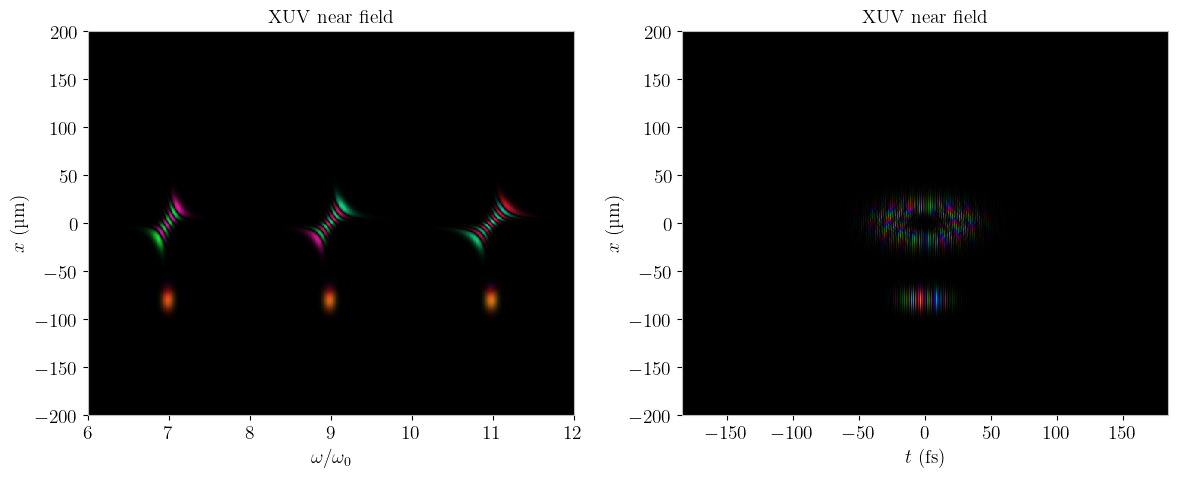

In [173]:
"Plot XUV near field"
%matplotlib inline
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(BOTHXUV_NF_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
#ax[0].set_xlim(0, np.max(q_list)+1)
ax[0].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel('$x$ (µm)')
ax[0].set_title('XUV near field')



'B - in xt plane'

extent=[t2_axis[0]/1e-15, t2_axis[-1]/1e-15, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(BOTHXUV_NF_st.T, mode='Amplitude')
ax[1].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$t$ (fs)')
ax[1].set_ylabel('$x$ (µm)')
ax[1].set_title('XUV near field')

plt.show()

In [174]:
"Propagate XUV to the far-field"

# we want the frequency axis to roughly span [-lam/w0, lam/w0] ~20mrad . We need to adjust N/L to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

BOTHXUV_FF_sw = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(BOTHXUV_NF_sw, axes=1), axis=1), axes=1)
BOTHXUV_FF_sw = BOTHXUV_FF_sw * (Lfoc_x/(Nx-1))
d=1
ff_x_axis = np.fft.fftshift(np.fft.fftfreq(Nx, Lfoc_x/(Nx-1)))*d
lam2_axis = 2*np.pi*3e8/w2

for i in range(len(BOTHXUV_FF_sw)):
    BOTHXUV_FF_sw[i] = np.interp(ff_x_axis*lam2_axis[-1], ff_x_axis*lam2_axis[i], BOTHXUV_FF_sw[i]) / lam2_axis[i] 

ff_x_axis = ff_x_axis*lam2_axis[-1]

C:\Users\tg263331\AppData\Local\Temp\ipykernel_2708\1262070407.py:10: RuntimeWarning: divide by zero encountered in divide
  lam2_axis = 2*np.pi*3e8/w2
C:\Users\tg263331\AppData\Local\Temp\ipykernel_2708\1262070407.py:13: RuntimeWarning: invalid value encountered in multiply
  BOTHXUV_FF_sw[i] = np.interp(ff_x_axis*lam2_axis[-1], ff_x_axis*lam2_axis[i], BOTHXUV_FF_sw[i]) / lam2_axis[i]


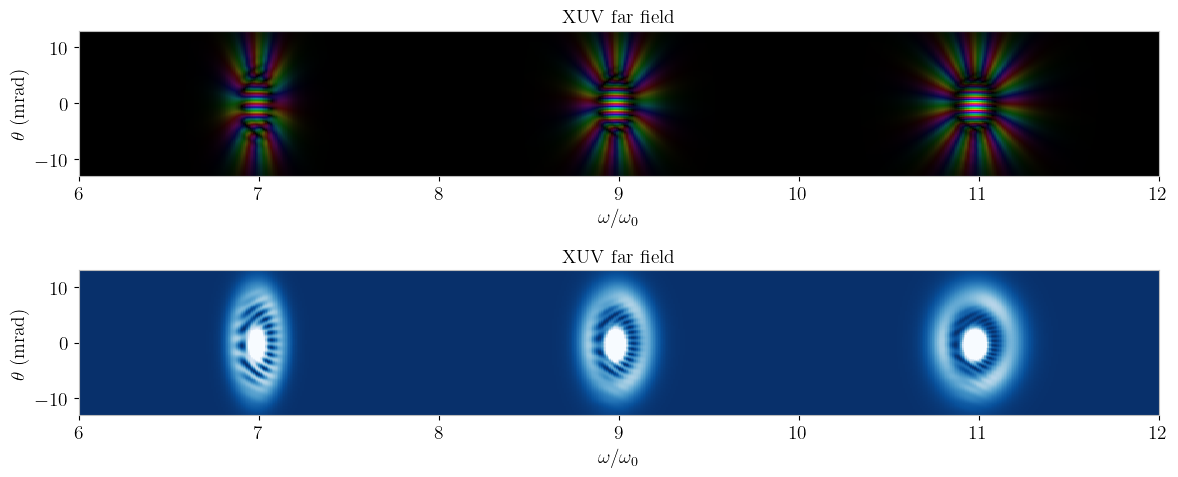

In [175]:
"Plot XUV far field"
%matplotlib inline
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, ff_x_axis[0]*1e3, ff_x_axis[-1]*1e3]

im = Graph.Phase2D().colorize(BOTHXUV_FF_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
#ax[0].set_xlim(0, np.max(q_list)+1)
ax[0].set_ylim(-13,13)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel(r'$\theta$ (mrad)')
ax[0].set_title('XUV far field')



'B - plot intensity, xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, ff_x_axis[0]*1e3, ff_x_axis[-1]*1e3]

ax[1].imshow(np.abs(BOTHXUV_FF_sw.T)**2 / np.nanmax(np.abs(BOTHXUV_FF_sw.T)**2), aspect='auto', extent=extent, cmap='Blues_r', vmin=0, vmax=0.2)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
ax[1].set_ylim(-13,13)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$\omega/\omega_0$')
ax[1].set_ylabel(r'$\theta$ (mrad)')
ax[1].set_title('XUV far field')

plt.show()

In [252]:
"NCHHG setup"

# Params
Goffset = 0
Gwaist = waist * 2
Gdw = dw / 2
Gscale = np.max(np.abs(FOC_PULSE_sw))/2 * 10
theta = 100e-3
Gphase = np.pi/2

# Gaussian pulse
FOC_G_sw = np.exp(-(foc_x - Goffset)**2/Gwaist**2) * np.exp(-(w-w0)**2/Gdw**2) * Gscale * np.exp(1j * Gphase)

# Add angle to stov pulse and add Gaussian pulse
NC_sw = FOC_PULSE_sw * np.exp(1j * 2*np.pi/lam * np.sin(theta) * foc_x) + FOC_G_sw
alpha = np.max(np.abs(FOC_PULSE_sw)) / np.max(np.abs(FOC_G_sw))
print(alpha)

# Focused pulse in time
NC_st, foc_xt_grid = Grating.Recombine(field_0=NC_sw, grid_xt=foc_xw_grid)

0.20107530643570626


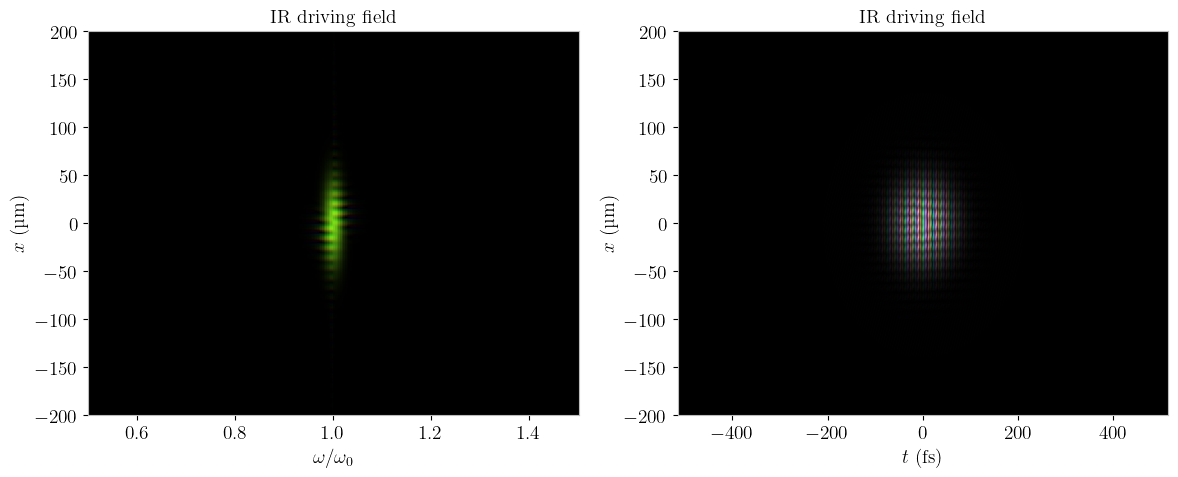

In [245]:
"Plot pulse at focus"
%matplotlib inline
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w_axis[0]/w0, w_axis[-1]/w0, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(NC_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(0.5, 1.5)
ax[0].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel('$x$ (µm)')
ax[0].set_title('IR driving field')



'B - in xt plane'

extent=[t_axis[0]/1e-15, t_axis[-1]/1e-15, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(NC_st.T, mode='Amplitude')
ax[1].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$t$ (fs)')
ax[1].set_ylabel('$x$ (µm)')
ax[1].set_title('IR driving field')

plt.show()

In [246]:
"HHG"

# Desired q range
q_list = [7, 9, 11]

# we want the frequency axis to span [-q-1, q+1]. We need to adjust N/T to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

max_w = (np.max(q_list)+3)*w0
factor = max_w /np.max(w_axis)*2 # by how much we must increase N/T
Lt2 = Lt/factor
t2_axis = np.linspace(-Lt2, Lt2, Nw)
foc_xt2_grid = np.meshgrid(foc_x_axis, t2_axis)

NC_st = NC_st.T
for i in range(len(NC_st)):
    NC_st[i] = np.interp(t2_axis, t_axis, NC_st[i])
NC_st = NC_st.T

# We apply the TSM formula to every time slice, for some harmonic orders q.
AG = ActiveGrating(qeff=3.5)
NCXUV_NF_st = 0

for q in q_list:
    NCXUV_NF_st += AG.Hq_NearField(IRfield=NC_st, q=q)

# XUV field in frequency
NCXUV_NF_sw, foc_xw2_grid = Grating.Disperse(field_0=NCXUV_NF_st, grid_xt=foc_xt2_grid)
w2 = foc_xw2_grid[1]
w2_axis = w2.T[0]
Lw2 = w2_axis[-1] - w2_axis[0]

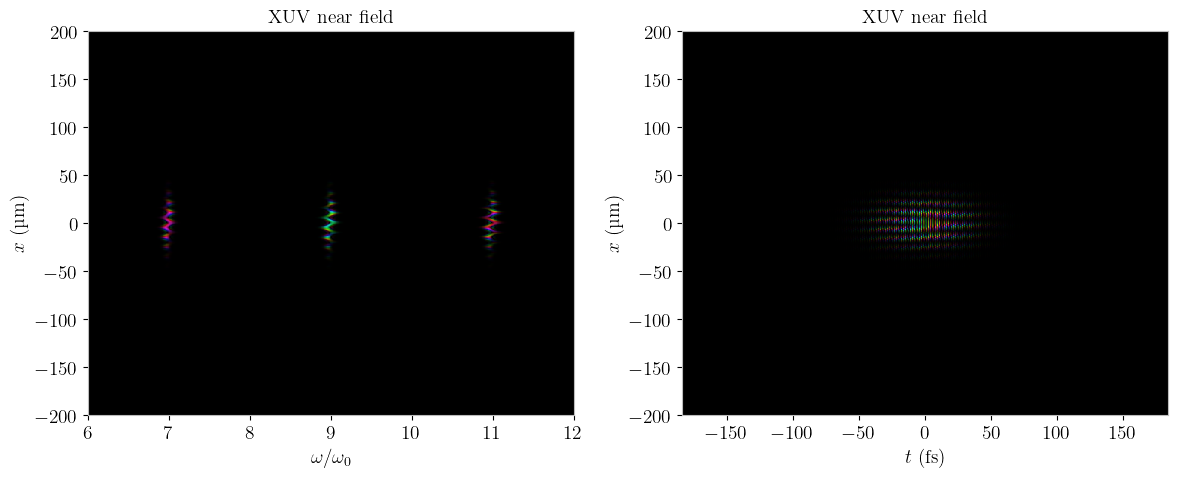

In [247]:
"Plot XUV near field"
%matplotlib inline
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(NCXUV_NF_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
#ax[0].set_xlim(0, np.max(q_list)+1)
ax[0].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel('$x$ (µm)')
ax[0].set_title('XUV near field')



'B - in xt plane'

extent=[t2_axis[0]/1e-15, t2_axis[-1]/1e-15, foc_x_axis[0]*1e6, foc_x_axis[-1]*1e6]

im = Graph.Phase2D().colorize(NCXUV_NF_st.T, mode='Amplitude')
ax[1].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_ylim(-200,200)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$t$ (fs)')
ax[1].set_ylabel('$x$ (µm)')
ax[1].set_title('XUV near field')

plt.show()

In [248]:
"Propagate XUV to the far-field"

# we want the frequency axis to roughly span [-lam/w0, lam/w0] ~20mrad . We need to adjust N/L to optimize this. 
# Then, to increase the spectral resolution we need to increase N and T by the same factor. Could be done by zero padding

NCXUV_FF_sw = np.fft.fftshift(np.fft.fft(np.fft.ifftshift(NCXUV_NF_sw, axes=1), axis=1), axes=1)
NCXUV_FF_sw = NCXUV_FF_sw * (Lfoc_x/(Nx-1))
d=1
ff_x_axis = np.fft.fftshift(np.fft.fftfreq(Nx, Lfoc_x/(Nx-1)))*d
lam2_axis = 2*np.pi*3e8/w2

for i in range(len(NCXUV_FF_sw)):
    NCXUV_FF_sw[i] = np.interp(ff_x_axis*lam2_axis[-1], ff_x_axis*lam2_axis[i], NCXUV_FF_sw[i]) / lam2_axis[i] 

ff_x_axis = ff_x_axis*lam2_axis[-1]

C:\Users\tg263331\AppData\Local\Temp\ipykernel_2708\176734865.py:10: RuntimeWarning: divide by zero encountered in divide
  lam2_axis = 2*np.pi*3e8/w2
C:\Users\tg263331\AppData\Local\Temp\ipykernel_2708\176734865.py:13: RuntimeWarning: invalid value encountered in multiply
  NCXUV_FF_sw[i] = np.interp(ff_x_axis*lam2_axis[-1], ff_x_axis*lam2_axis[i], NCXUV_FF_sw[i]) / lam2_axis[i]


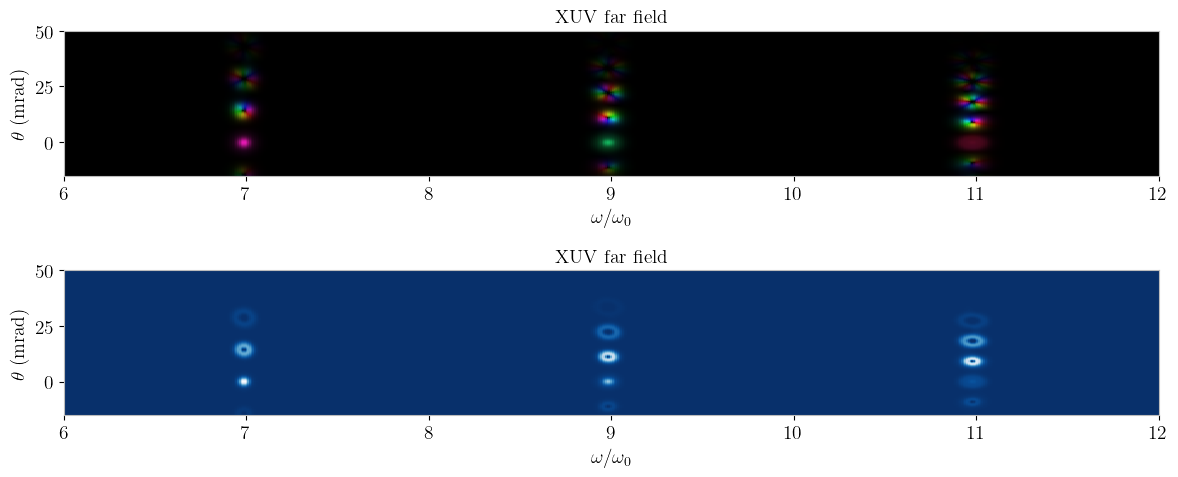

In [249]:
"Plot XUV far field"
%matplotlib inline
fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(12, 5))

'A - in xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, ff_x_axis[0]*1e3, ff_x_axis[-1]*1e3]

im = Graph.Phase2D().colorize(NCXUV_FF_sw.T, mode='Amplitude')
ax[0].imshow(im, aspect='auto', extent=extent)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
ax[0].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
#ax[0].set_xlim(0, np.max(q_list)+1)
ax[0].set_ylim(-15,50)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[0].set_xlabel('$\omega/\omega_0$')
ax[0].set_ylabel(r'$\theta$ (mrad)')
ax[0].set_title('XUV far field')



'B - plot intensity, xw plane'

extent=[w2_axis[0]/w0, w2_axis[-1]/w0, ff_x_axis[0]*1e3, ff_x_axis[-1]*1e3]

ax[1].imshow(np.abs(NCXUV_FF_sw.T)**2 / np.nanmax(np.abs(NCXUV_FF_sw.T)**2), aspect='auto', extent=extent, cmap='Blues_r', vmin=0, vmax=1)

#cbar = plt.colorbar(im, orientation='vertical', ticks=[-1, 0, 1], shrink=0.5, aspect=15)
#cbar.ax.set_yticklabels(['-1', '0', '1'])
#cbar.ax.set_ylabel('$\Re E$')
#ax[0].set_xlim(0, 2)
ax[1].set_xlim(np.min(q_list)-1, np.max(q_list)+1)
ax[1].set_ylim(-15,50)
#ax.set_xticks([-40, -20, 0, 20, 40], [-40, -20, 0, 20, 40])
#ax.set_yticks([-2, -1, 0, 1, 2], [-2, -1, 0, 1, 2])

ax[1].set_xlabel('$\omega/\omega_0$')
ax[1].set_ylabel(r'$\theta$ (mrad)')
ax[1].set_title('XUV far field')

plt.show()